# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > TABLE OF CONTENTS<br><div>  
* [IMPORTS](#1)
* [INTRODUCTION](#2)
* [DATA PROCESSING](#3)
* [MODEL TRAINING](#4) 
* [MODEL INFERENCING](#5) 
* [OUTRO](#6)

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff"> PACKAGE IMPORTS<br><div>

In [1]:
import numpy as np # Linear Algebra
import pandas as pd # Handling DataFrame
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Data Visualization
plt.style.use(style='fivethirtyeight')
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from tabulate import tabulate
import pickle

from scipy import stats # Statistical Analysis
import re
import warnings # To mitigate any unwanted warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff"> INTRODUCTION<br><div>

<div class="alert alert-block alert-info" style = "font-family: Cambria Math;font-size: 115%; color: black; background-color: #e6f9ff; border: dashed black 1.0px; padding: 3.5px" >
1.<b>Classification  Algorithms such as:</b> KNN, Naive Bayes, Decision Tree, Random Forest, MLP, SVM. <br>
2. This notebook aims to train a baseline model using a simple CV strategy/GridSearch/Randomized Search as advance techniques we  will use <b>OPTUNA</b><br>
3. This is a continuation from our first first class of <b>24MLE01</b> data curation notebook and heart disease dataset. We continue the analysis herewith and train models to elicit a CV score.<br>
4. After building a succesful model we will deploy the model using <b>FAST API</b>. <br> 
</div>

<a id="2.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size: 90%; text-align:left;padding:4.0px; background: maroon; border-bottom: 5px solid black"> VERSION DETAILS<br><div>

for packages and  their version will be written here for deployment purposes

<a id="2.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size: 90%; text-align:left;padding:4.0px; background: maroon; border-bottom: 5px solid black"> CONFIGURATION PARAMETERS<br><div>

Parameters and their description

<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #003380; border-bottom: 10px solid #80ffff"> DATA PROCESSING<br><div>

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ds-mahbub/24MLE01_Machine-Learning-Engineer/KNN/Classification/data/heart_disease.csv')
data.sample(5)

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
184599,No,56.96,Yes,No,No,30.0,10.0,Yes,Male,50-54,White,Yes,No,Fair,10.0,No,No,No
281366,No,28.25,Yes,No,No,0.0,10.0,Yes,Female,65-69,White,Yes,Yes,Good,6.0,No,No,No
148284,No,23.57,Yes,No,No,0.0,0.0,No,Male,35-39,Black,No,No,Very good,8.0,No,No,No
234007,No,21.63,No,No,No,0.0,0.0,No,Female,18-24,Other,No,Yes,Very good,9.0,Yes,No,No
28457,No,25.11,No,No,No,0.0,0.0,No,Male,18-24,Black,No,Yes,Good,8.0,No,No,No


In [3]:
def rename_columns(data):
    new_columns = []
    for column in data.columns:
        new_column_name = re.sub(r'(?<!^)(?=[A-Z][a-z])', '_', column).lower()
        new_columns.append(new_column_name)
    data.columns = new_columns
rename_columns(data)
print(data.columns)

Index(['heart_disease', 'bmi', 'smoking', 'alcohol_drinking', 'stroke',
       'physical_health', 'mental_health', 'diff_walking', 'sex',
       'age_category', 'race', 'diabetic', 'physical_activity', 'gen_health',
       'sleep_time', 'asthma', 'kidney_disease', 'skin_cancer'],
      dtype='object')


In [4]:
print(f"Summary Of The Dataset with numerical columns :")
data.describe()

Summary Of The Dataset with numerical columns :


,bmi,physical_health,mental_health,sleep_time
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [5]:
# # Descriptive Statistics
# df2 = pd.DataFrame() # Creating an empty DataFrame. In this dataframe different columns will be created for mean, median, mode etc.
# # Measure of central tendency
# df2["Mean"] = data.mean() # for mean column of all features
# df2['Median'] = data.median() # for median column of all features
# df2["Mode"] = data.mode().iloc[0] # mode column for all features
# # Measure of dispersion
# df2['Range'] = [np.ptp(df[i]) for i in df.columns]
# df2["Stdev"] = data.std() # standard deviation column for all features 
# df2["Variance"] = data.var() # variance columns for all features
# df2['IQR'] = [stats.iqr(df[i]) for i in df.columns]
# df2["Skewness"] = data.skew() # skewness column for all features
# df2["Kurtosis"] = data.kurt() # kurtosis column for all features
# df2["25%"] = data.quantile(q = 0.25, axis = 0) # this will calculate the 1st quantile for all features
# df2["50%"] = data.quantile(q = 0.50, axis = 0) # this will calculate the 2nd quantile for all features 
# df2["75%"] = data.quantile(q = 0.75, axis = 0) # for 3rd quantile of all features
# df2 = df2.T
# df2

# You can do this for small size dataset

In [6]:
# Information about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   heart_disease      319795 non-null  object 
 1   bmi                319795 non-null  float64
 2   smoking            319795 non-null  object 
 3   alcohol_drinking   319795 non-null  object 
 4   stroke             319795 non-null  object 
 5   physical_health    319795 non-null  float64
 6   mental_health      319795 non-null  float64
 7   diff_walking       319795 non-null  object 
 8   sex                319795 non-null  object 
 9   age_category       319795 non-null  object 
 10  race               319795 non-null  object 
 11  diabetic           319795 non-null  object 
 12  physical_activity  319795 non-null  object 
 13  gen_health         319795 non-null  object 
 14  sleep_time         319795 non-null  float64
 15  asthma             319795 non-null  object 
 16  ki

In [7]:
# Checking Missing and duplicates
print(f'Number of Missing values: \n{data.isna().sum()}')
print('---------------------------------------------------')
print(f'Number of Duplicate values: {data.duplicated().sum()}')

Number of Missing values: 
heart_disease        0
bmi                  0
smoking              0
alcohol_drinking     0
stroke               0
physical_health      0
mental_health        0
diff_walking         0
sex                  0
age_category         0
race                 0
diabetic             0
physical_activity    0
gen_health           0
sleep_time           0
asthma               0
kidney_disease       0
skin_cancer          0
dtype: int64
---------------------------------------------------
Number of Duplicate values: 18078


In [8]:
# Dropping the duplicate values
data.drop_duplicates(inplace = True)

In [9]:
# Unique value of each colulmns
for column in data.columns:
     print(f"{column}:--->{len(data[column].unique())}")

heart_disease:--->2
bmi:--->3604
smoking:--->2
alcohol_drinking:--->2
stroke:--->2
physical_health:--->31
mental_health:--->31
diff_walking:--->2
sex:--->2
age_category:--->13
race:--->6
diabetic:--->4
physical_activity:--->2
gen_health:--->5
sleep_time:--->24
asthma:--->2
kidney_disease:--->2
skin_cancer:--->2


In [10]:
# Getting the numerical columns
num_cols = data.select_dtypes(include = ['number']).columns.tolist()
cat_cols = data.select_dtypes(include = ['object', 'category']).columns.tolist()

print(f'Numerical Columns: \n{num_cols}\n\nCategorical Columns: \n{cat_cols}')

Numerical Columns: 
['bmi', 'physical_health', 'mental_health', 'sleep_time']

Categorical Columns: 
['heart_disease', 'smoking', 'alcohol_drinking', 'stroke', 'diff_walking', 'sex', 'age_category', 'race', 'diabetic', 'physical_activity', 'gen_health', 'asthma', 'kidney_disease', 'skin_cancer']


In [11]:
data.select_dtypes(include = ['object', 'category']).head()

,heart_disease,smoking,alcohol_drinking,stroke,diff_walking,sex,age_category,race,diabetic,physical_activity,gen_health,asthma,kidney_disease,skin_cancer
0,No,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,No,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No


In [12]:
data.select_dtypes(include = ['number']).head()

,bmi,physical_health,mental_health,sleep_time
0,16.60,3.0,30.0,5.0
1,20.34,0.0,0.0,7.0
2,26.58,20.0,30.0,8.0
3,24.21,0.0,0.0,6.0
4,23.71,28.0,0.0,8.0


### **To get knowledge about the dataset you can perform EDA**
1. Univariate Analysis
2. Bivariate Analysis
3. Multivariate Analysis

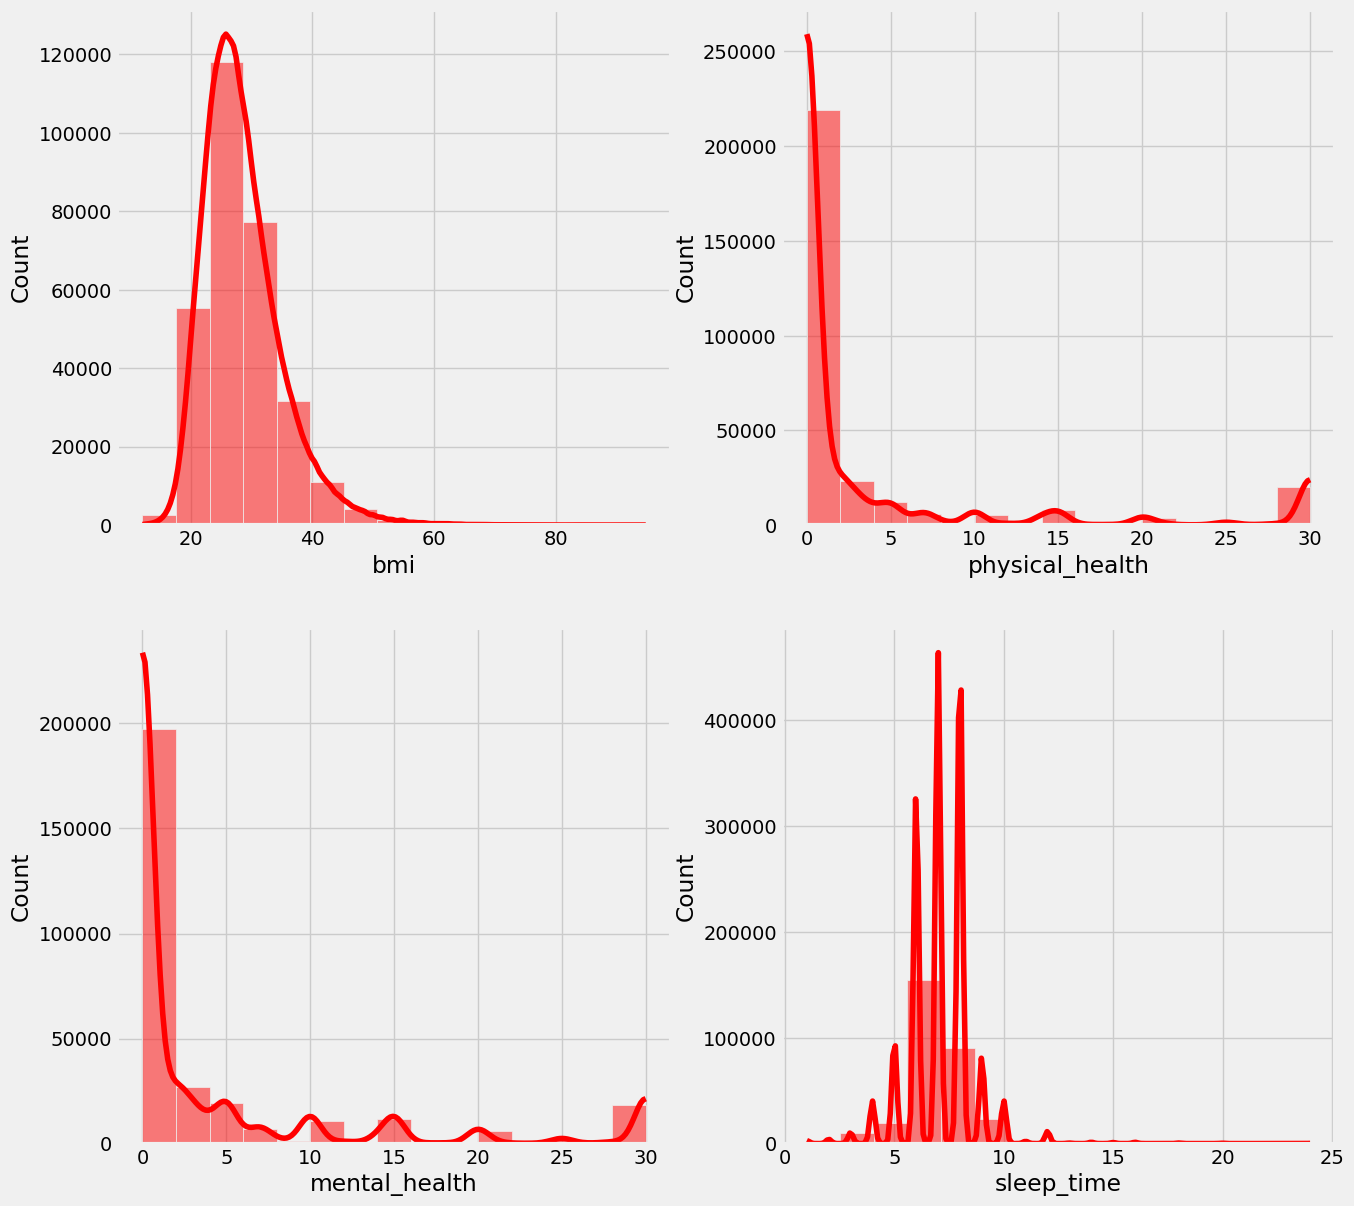

In [13]:
num_cols = ['bmi', 'physical_health', 'mental_health', 'sleep_time']
plt.figure(figsize=(14, 14))
for i,col in enumerate(num_cols):
    plt.subplot(2, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'r')
plt.show()

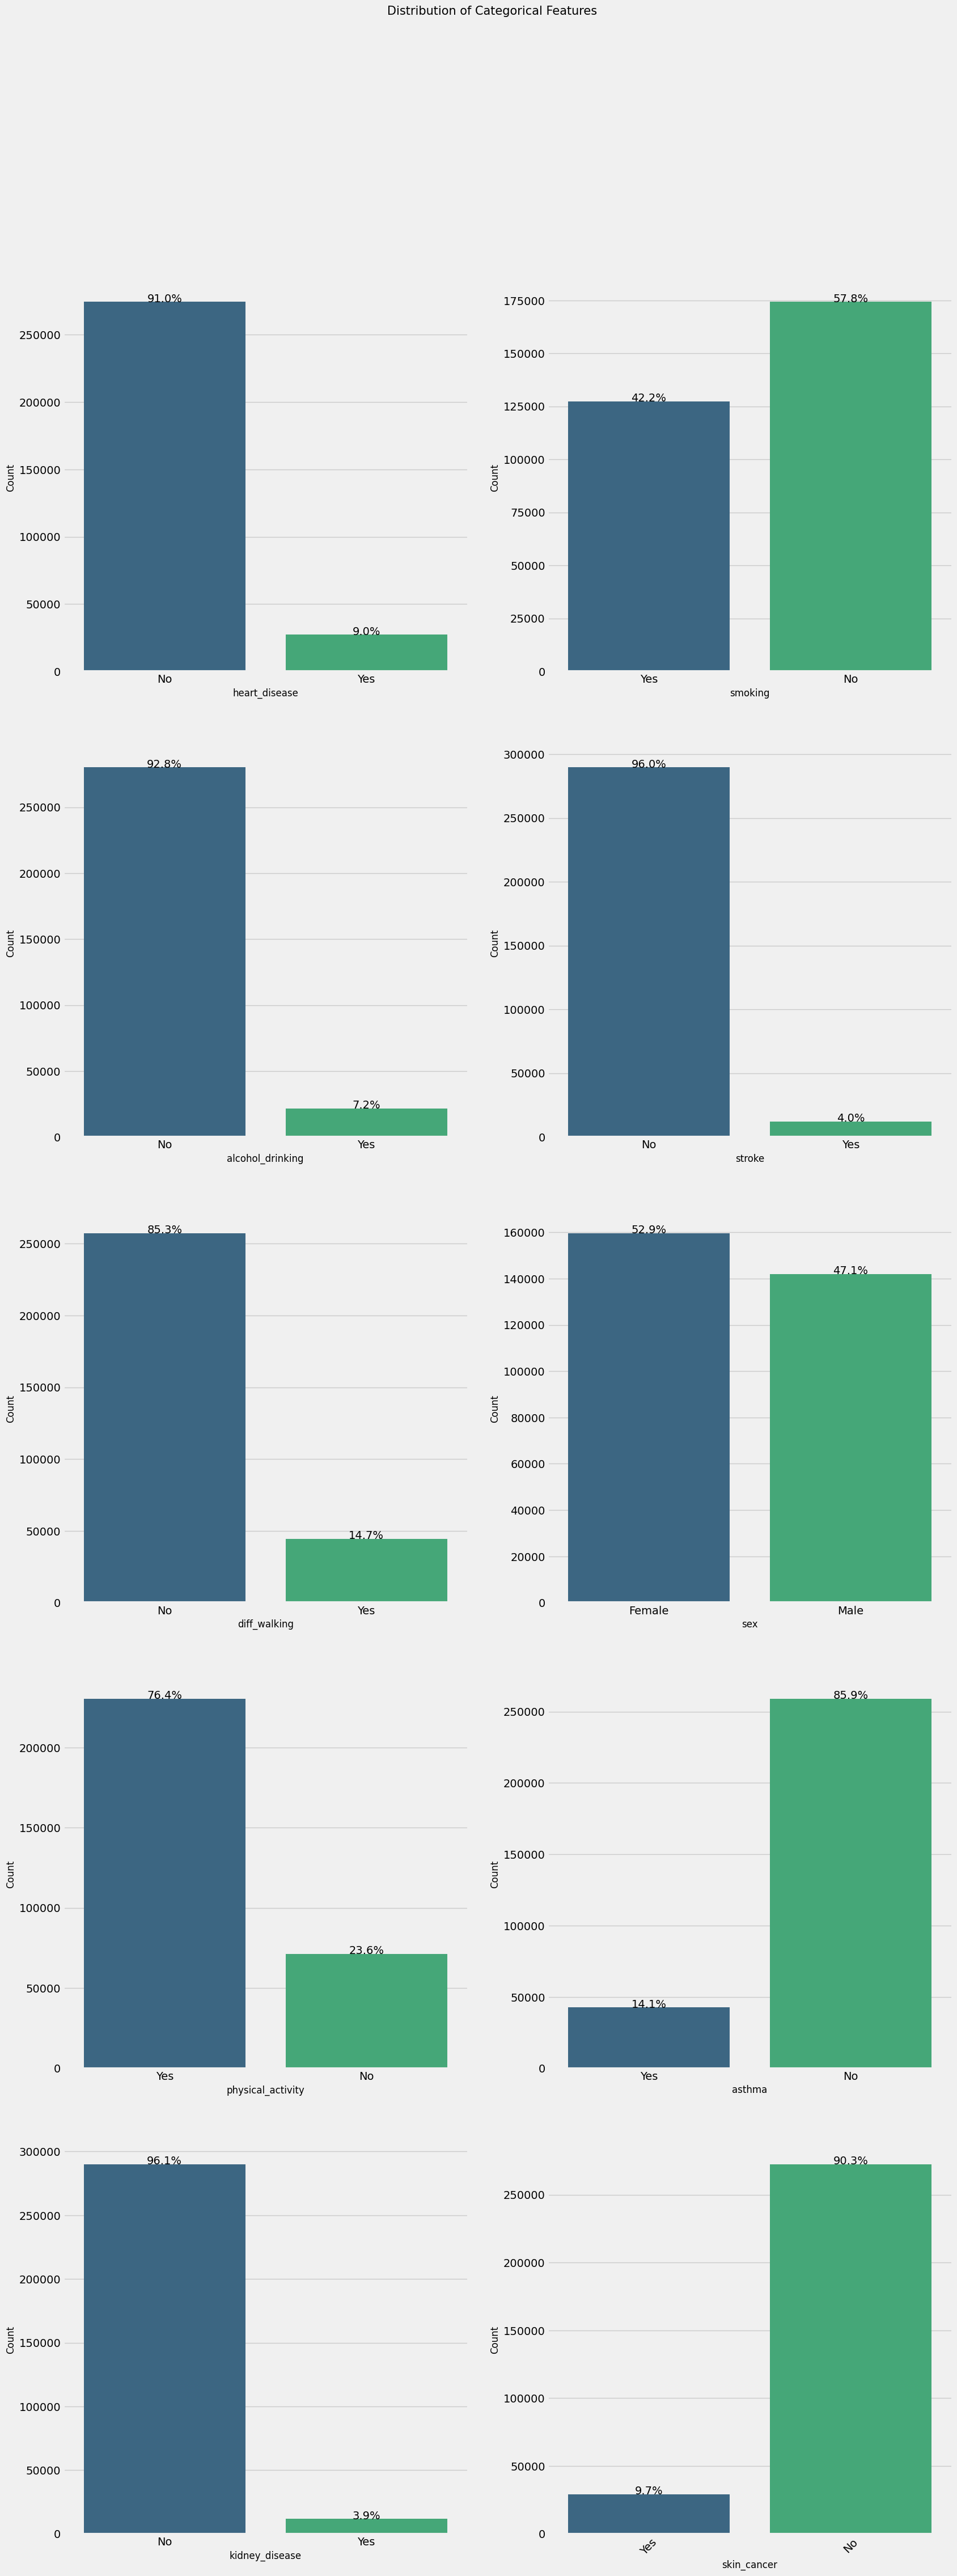

In [14]:
cat_cols = ['heart_disease', 'smoking', 'alcohol_drinking', 'stroke', 'diff_walking', 'sex', 'physical_activity', 'asthma', 'kidney_disease', 'skin_cancer']
n = len(cat_cols)
ncol = 2
nrow = int(np.ceil(n/ncol)) 
fig, axs = plt.subplots(5, 2, figsize = (18, 49))
i = 0
for col in cat_cols:
    ax = axs[i // ncol, i % ncol]
    sns.countplot(data=data, x=col, palette='viridis', ax=ax)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    plt.xticks(rotation = 45)
    sns.despine(right=True, ax=ax)
    sns.despine(offset=0, trim=False, ax=ax)

    total = float(len(data))
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:.1f}%'.format((height / total) * 100), ha="center")

    i += 1
    
if n % 2 != 0:
    axs[-1, -1].axis('off')

plt.suptitle('Distribution of Categorical Features', fontsize=15)
plt.xticks(rotation = 45)
plt.show()

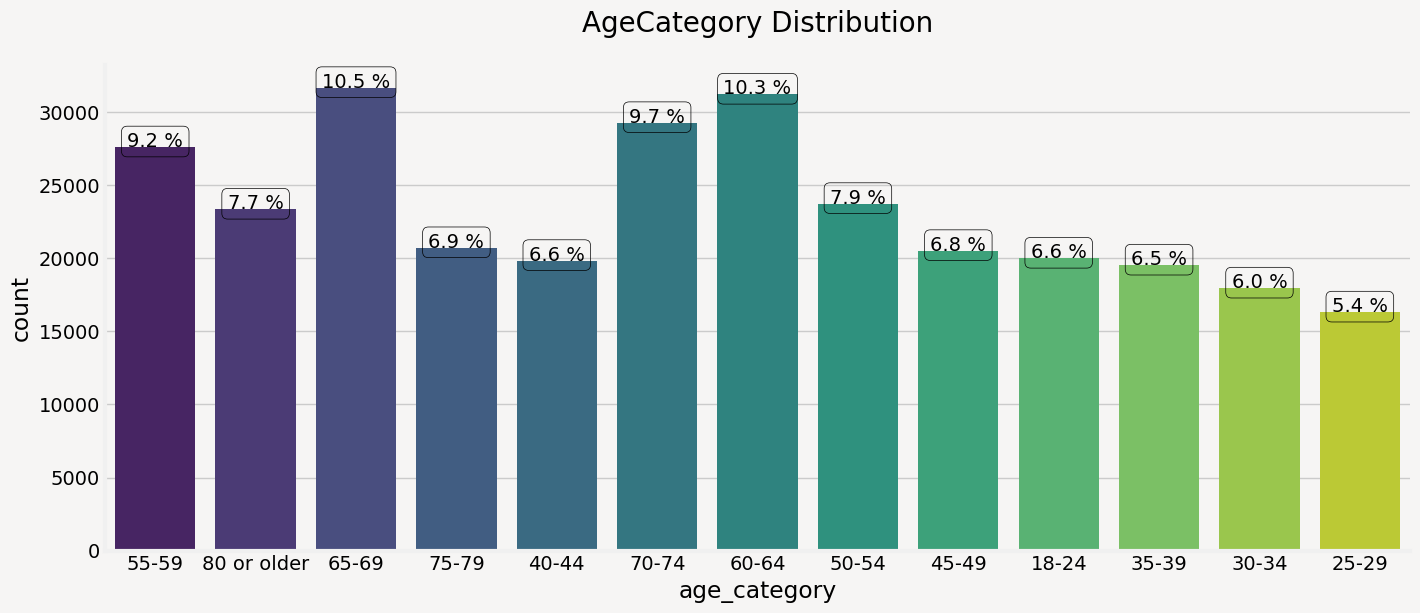

In [15]:
plt.figure(figsize=(15, 6),facecolor='#F6F5F4')
total = float(len(data))
ax = sns.countplot(x=data['age_category'], palette='viridis')
ax.set_facecolor('#F6F5F4')

for p in ax.patches:
    
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.1f} %'.format((height/total)*100), ha="center",
           bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

ax.set_title('AgeCategory Distribution', fontsize=20, y=1.05)
sns.despine(right=True)

In [16]:
### Feature Engineering
df1= data.copy()

<div style="background-color: white; padding: 20px; border-radius: 8px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); color: #333; font-family: Arial, sans-serif;">
    <h3 style="font-size: 18px; font-weight: bold; color: #FF5733 ; margin-bottom: 10px;"> Encoding Categorical Variables:  </h3>
    
</div>


In [17]:
df1 = df1.replace({'No': 0, 'Yes': 1})  # this will replace all the "No" with 0 and 'Yes' with 1
df1["sex"] = df1["sex"].replace({'Female': 0, 'Male': 1}) # 'Female' with zero and male  with 1

# diabetic mapping
diabetic_mapping = {
    'No': 0,
    'No, borderline diabetes': 0,
    'Yes': 1,
    'Yes (during pregnancy)': 1
}

race_mapping = {
    'American Indian/Alaskan Native': 0,
    'Asian': 1,
    'Black': 2,
    'Hispanic': 3,
    'Other': 4,
    'White': 5
}

gen_health_mapping = {
    'Poor': 0,
    'Fair': 1,
    'Good': 2,
    'Very good': 3,
    'Excellent': 4
}

age_mapping = {
    '18-24': 0,
    '25-29': 1,
    '30-34': 2,
    '35-39': 3,
    '40-44': 4,
    '45-49': 5,
    '50-54': 6,
    '55-59': 7,
    '60-64': 8,
    '65-69': 9,
    '70-74': 10,
    '75-79': 11,
    '80 or older': 12
}

# Executing all the mappings

df1['diabetic'] = df1['diabetic'].replace(diabetic_mapping).astype(int)
df1['race'] = df1['race'].map(race_mapping).astype(int)
df1['gen_health'] = df1['gen_health'].replace(gen_health_mapping).astype(int)
df1['age_category'] = df1['age_category'].map(age_mapping).astype(int)

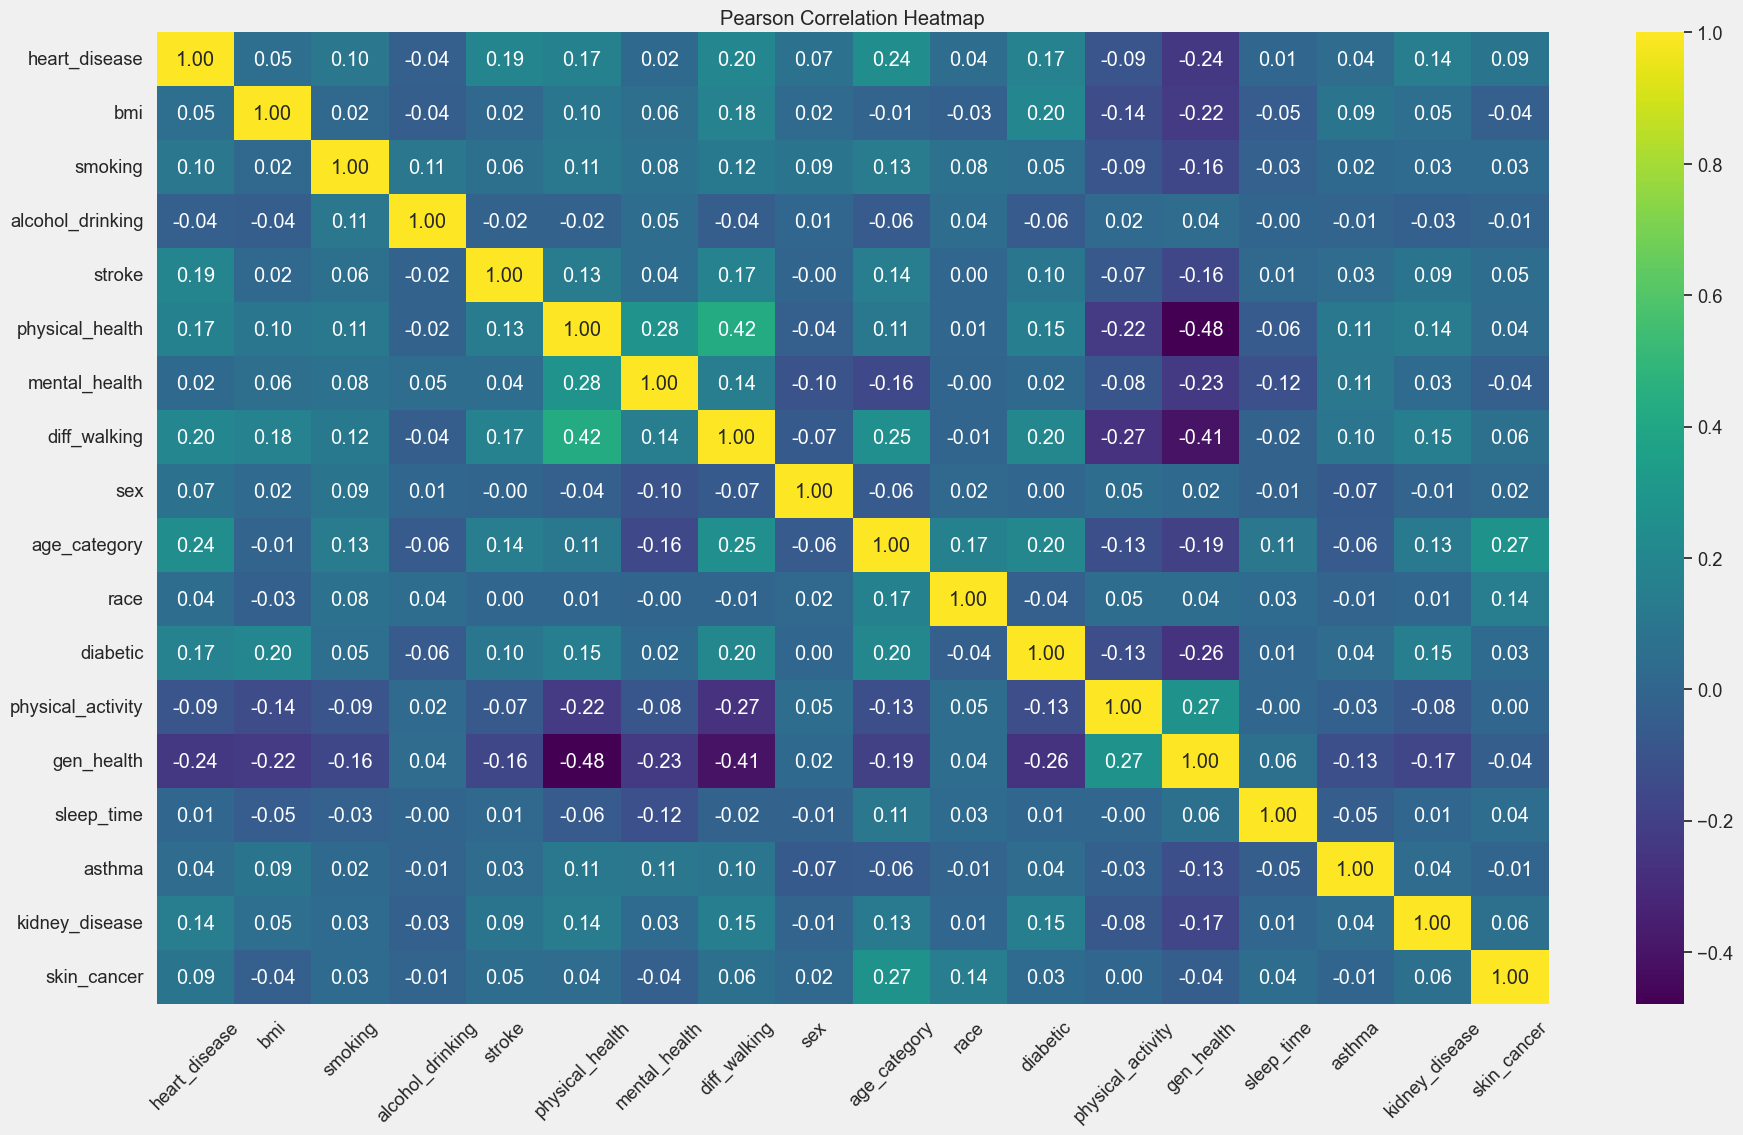

In [18]:
## Correlation
pearson_corr = df1.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(20, 12))
sns.set(font_scale=1.2)
sns.heatmap(pearson_corr, annot=True, cmap='viridis', fmt=".2f")
plt.title('Pearson Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [19]:
df2 = df1.copy(deep = True)

In [20]:
df2.head()

,heart_disease,bmi,smoking,alcohol_drinking,stroke,physical_health,mental_health,diff_walking,sex,age_category,race,diabetic,physical_activity,gen_health,sleep_time,asthma,kidney_disease,skin_cancer
0,0,16.60,1,0,0,3.0,30.0,0,0,7,5,1,1,3,5.0,1,0,1
1,0,20.34,0,0,1,0.0,0.0,0,0,12,5,0,1,3,7.0,0,0,0
2,0,26.58,1,0,0,20.0,30.0,0,1,9,5,1,1,1,8.0,1,0,0
3,0,24.21,0,0,0,0.0,0.0,0,0,11,5,0,0,2,6.0,0,0,1
4,0,23.71,0,0,0,28.0,0.0,1,0,4,5,0,1,3,8.0,0,0,0


In [21]:
X = df2.drop(['heart_disease'], axis=1)
y = df2['heart_disease']

In [22]:
scaler = MinMaxScaler(feature_range = (0, 1))
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)


smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [23]:
print(f"Outcome class size before SMOTE: {y.value_counts()}")
print(f"Outcome class size before SMOTE: {y_resampled.value_counts()}")

Outcome class size before SMOTE: heart_disease
0    274456
1     27261
Name: count, dtype: int64
Outcome class size before SMOTE: heart_disease
0    274456
1    274456
Name: count, dtype: int64


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

<Axes: >

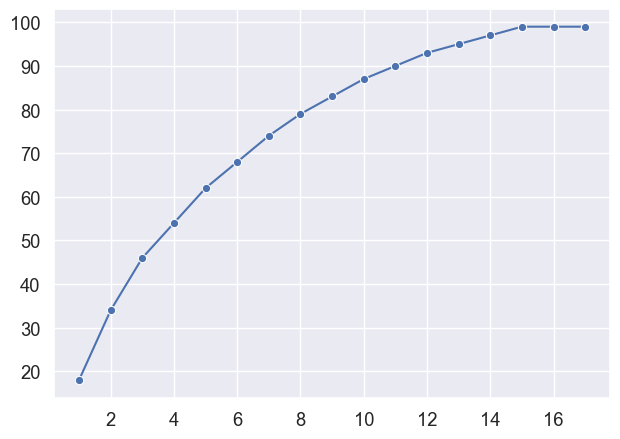

In [25]:
decom = PCA(svd_solver='auto') 
X_pca = decom.fit_transform(X_scaled)
ex_var = np.cumsum(np.round(decom.explained_variance_ratio_, 2) * 100)
sns.lineplot(y=ex_var, x=np.arange(1, len(ex_var) + 1), marker='o')

In [26]:
# param_dist_rf = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy'],
# }

# rf = RandomForestClassifier()

# randomized_search_rf = RandomizedSearchCV(
#     rf,
#     param_distributions=param_dist_rf,
#     n_iter=10,
#     cv=5,
#     scoring='accuracy',
#     random_state=42,
#     n_jobs=-1
# )


In [27]:
rf = RandomForestClassifier(n_estimators= 200, 
                            min_samples_split=5, 
                            min_samples_leaf= 1, 
                            max_depth=30, 
                            criterion= 'gini',
                            bootstrap= False)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=30, min_samples_split=5,
                       n_estimators=200)

In [28]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

In [29]:
print("\nConfusion Matrix for Random Forest:")
print(conf_mat)
print("\nAccuracy of Random Forest Classifier:", accuracy * 100, '\n')
print("Classification Report for Random Forest:")
print(classification_report(y_test, y_pred))


Confusion Matrix for Random Forest:
[[51217  3686]
 [ 4003 50877]]

Accuracy of Random Forest Classifier: 92.99618337994042 

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     54903
           1       0.93      0.93      0.93     54880

    accuracy                           0.93    109783
   macro avg       0.93      0.93      0.93    109783
weighted avg       0.93      0.93      0.93    109783



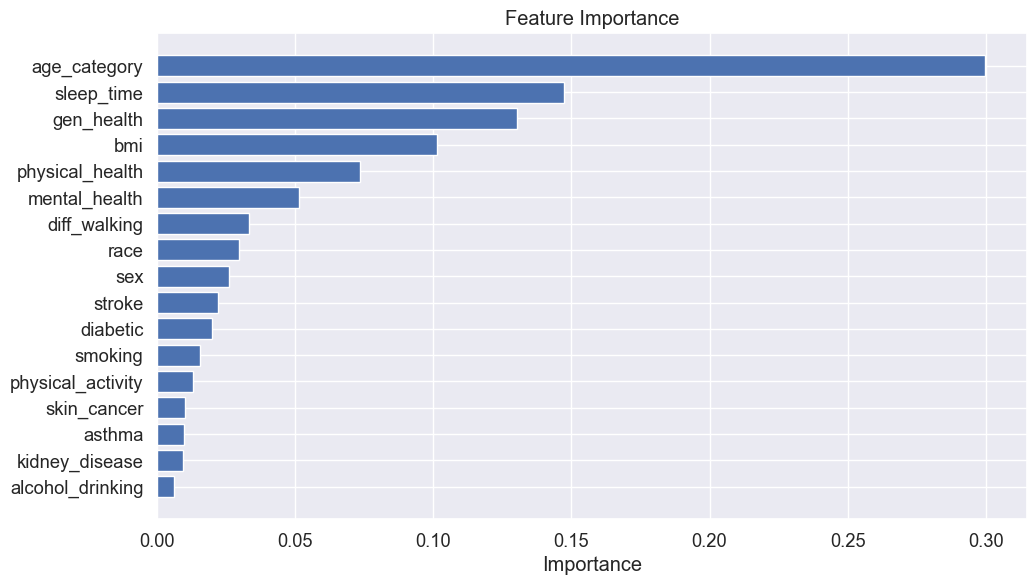

In [30]:
feature_importance_values = rf.feature_importances_


feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance_values})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  
plt.show()

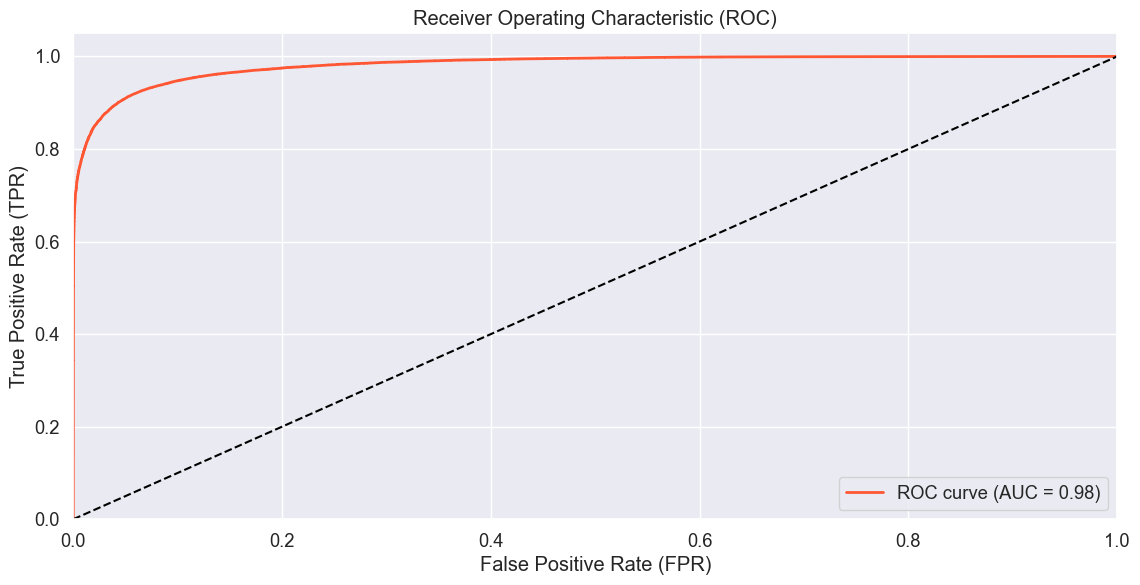

Area Under Curve (AUC): 0.9812283477130539


In [31]:
y_pred_prob = rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='#FF5733', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

print("Area Under Curve (AUC):", roc_auc)

In [32]:
with open('rf.pkl', 'wb') as f:
    pickle.dump(rf, f)